# Culstering Exploration

In [1]:
1

1

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import cartopy.crs as crs
import matplotlib
from sklearn.cluster import KMeans


Data downloaded from

In [2]:
# https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240416T162518.L2.OC_AOP.V1_0_0.NRT.nc

In [3]:
# https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240413T175156.L2.OC_AOP.V1_0_0.NRT.nc

In [ ]:
# https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240420T170201.L2.OC_AOP.V1_0_0.NRT.nc

In [4]:
fn = 'data/PACE_OCI.20240416T162518.L2.OC_AOP.V1_0_0.NRT.nc'

In [3]:
fn = 'data/PACE_OCI.20240413T175156.L2.OC_AOP.V1_0_0.NRT.nc'

In [3]:
fn = 'data/PACE_OCI.20240420T170201.L2.OC_AOP.V1_0_0.NRT.nc'

In [3]:
fn = 'data/PACE_OCI.20240413T175656.L2.OC_AOP.V1_0_0.NRT.nc'

In [ ]:
# https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240413T175656.L2.OC_AOP.V1_0_0.NRT.nc

In [4]:
def load_oci_l2(fn, full_flag = True):
    # create the initial dataset so that we have all the attributes
    xds = xr.open_dataset(fn)
    # open the file with netCDF to get all the actual data
    dataset = Dataset(fn)
    
    # grab the necessary group data
    gd    = dataset.groups['geophysical_data']
    nav   = dataset.groups['navigation_data']
    lons  = nav.variables["longitude"][:]
    lats  = nav.variables["latitude"][:]
    flags = gd.variables["l2_flags"][:]
    wls = dataset.groups['sensor_band_parameters']['wavelength_3d'][:].data

    # create the dataset, now we're only adding in Rrs
    # but the options are: ['Rrs', 'Rrs_unc', 'aot_865', 'angstrom', 'avw', 'l2_flags']
    rrs_xds = xr.Dataset({'Rrs':(('x', 'y', 'wl'),gd.variables['Rrs'][:].data)},
                        coords = {'latitude': (('x', 'y'), lats),
                                  'longitude': (('x', 'y'), lons),
                                  'wavelength' : ('wl', wls)},
                        attrs={'variable':'Remote sensing reflectance'})
    
    # merge back into the xarray dataset with all the attributes
    xds['Rrs'] = rrs_xds.Rrs
    # replace nodata areas with nan
    xds = xds.where(xds['Rrs'] != -32767.0)

    # eliminate everything that isn't a flag bit of 0 (meaning no flags)
    if full_flag:
        xds['Rrs'] = xr.where(xr.DataArray(flags.data, dims=['x', 'y'])==0, xds['Rrs'], np.nan)
        
    return(xds)

this specific sample has some weird high and low values

In [5]:
xds = load_oci_l2(fn, full_flag = False)

In [6]:
xds['Rrs'] = xr.where(xds['Rrs']>-10, xds['Rrs'], np.nan)

In [7]:
xds['Rrs'] = xr.where(xds['Rrs']<100, xds['Rrs'], np.nan)

In [8]:
wls = xds.wavelength

(array([1.07000e+03, 1.61097e+05, 4.03920e+04, 4.16600e+03, 4.70000e+02,
        9.30000e+01, 2.40000e+01, 2.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([-0.01     , -0.0029154,  0.0041692,  0.0112538,  0.0183384,
         0.025423 ,  0.0325076,  0.0395922,  0.0466768,  0.0537614,
         0.060846 ], dtype=float32),
 <BarContainer object of 10 artists>)

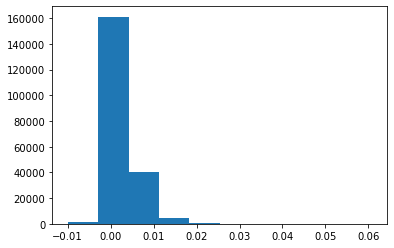

In [9]:
plt.hist(xds.Rrs[:,:,42].values.flatten())

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


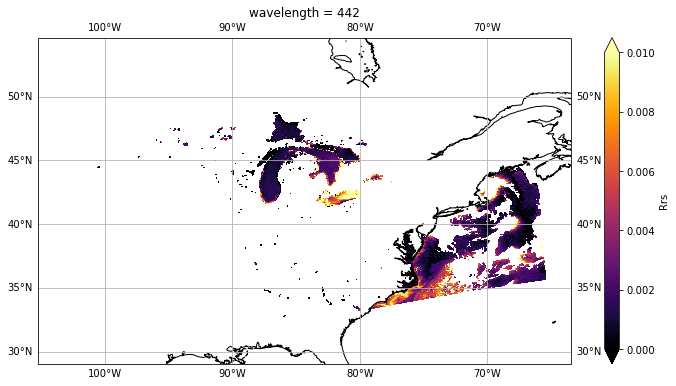

In [13]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

xds.Rrs[:,:,42].plot(ax=ax, x='longitude', y='latitude', vmin=0.00,vmax=0.01, cmap='inferno')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

In [9]:
# xds_subset = xds.where((xds.longitude > -72.5) & (xds.longitude < -70))
# xds_subset = xds_subset.where((xds_subset.latitude > 36) & (xds_subset.latitude < 42))

In [10]:
# xds_subset = xds.where((xds.longitude > -94) & (xds.longitude < -82))
# xds_subset = xds_subset.where((xds_subset.latitude > 22) & (xds_subset.latitude < 32))

In [10]:
xds_subset = xds.where((xds.longitude > -78) & (xds.longitude < -73))
xds_subset = xds_subset.where((xds_subset.latitude > 33) & (xds_subset.latitude < 40))

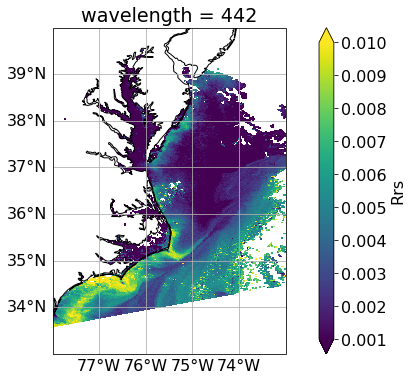

In [225]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))

ax.coastlines(resolution='10m')
# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

ax.set_xlim(-78,-73)
ax.set_ylim(33,40)

xds_subset.Rrs[:,:,42].plot(ax=ax, x='longitude', y='latitude', vmin=0.001,vmax=0.01, cmap='viridis')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# fig.tight_layout()

plt.savefig('figs/442nm_pace_map.png',dpi=300)

plt.show()

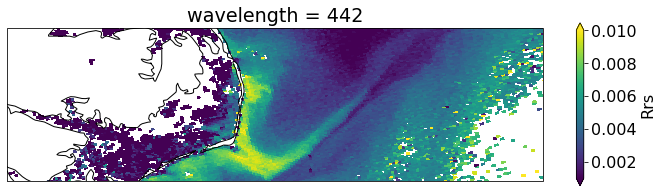

In [395]:
fig, ax = plt.subplots(figsize=(12,3), subplot_kw=dict(projection=crs.PlateCarree()))

ax.coastlines(resolution='10m')
# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

ax.set_xlim(-77,-73.5)
ax.set_ylim(35,36)

xds_subset.Rrs[:,:,42].plot(ax=ax, x='longitude', y='latitude', vmin=0.001,vmax=0.01, cmap='viridis')

# gl = ax.gridlines(draw_labels=False)
# gl.top_labels = False
# gl.right_labels = False

# fig.tight_layout()

# plt.savefig('figs/442nm_pace_map.png',dpi=300)

plt.show()

(array([1.20000e+01, 1.65319e+05, 2.06010e+04, 1.19840e+04, 6.44100e+03,
        2.83300e+03, 4.75000e+02, 6.20000e+01, 2.00000e+00, 2.00000e+00]),
 array([-0.008188 , -0.0018754,  0.0044372,  0.0107498,  0.0170624,
         0.023375 ,  0.0296876,  0.0360002,  0.0423128,  0.0486254,
         0.054938 ], dtype=float32),
 <BarContainer object of 10 artists>)

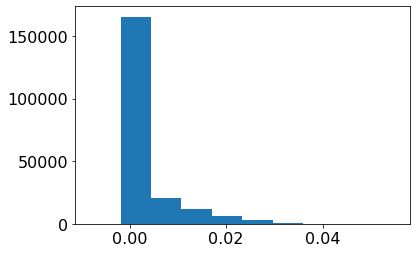

In [235]:
plt.hist(xds.Rrs[:,:,100].values.flatten())

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


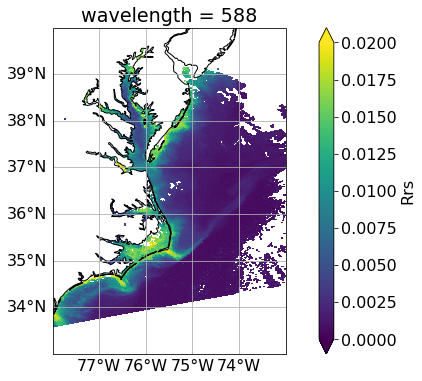

In [224]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

ax.set_xlim(-78,-73)
ax.set_ylim(33,40)

xds_subset.Rrs[:,:,100].plot(ax=ax, x='longitude', y='latitude', vmin=0.00,vmax=0.02, cmap='viridis')

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# fig.tight_layout()

plt.savefig('figs/588nm_pace_map.png',dpi=300)

plt.show()

Make a mask to only include non nan and non infinte values and we're removing the first 40 bands because they are so noisy

In [95]:
wls[42]

<xarray.DataArray 'wavelength' ()>
array(442, dtype=int32)
Coordinates:
    wavelength  int32 442

In [160]:
flat_xds = xds_subset.Rrs.values.reshape(-1,184)

flat_xds = flat_xds[:,42:]

# mask = ~np.isnan(flat_xds[:,40])
# mask = np.isfinite(flat_xds[:,40])

mask = np.all(np.isfinite(flat_xds), axis=1)

# we're going to normalize by 38 so we want to ensure it isn't zero or negative or it will bias our clusters
mask = np.logical_and(mask, flat_xds[:,38] > 0.00001)

masked_flat_xds = flat_xds[mask]

We choose wavelength 537 because it has the least negatives to begin with

Grab a random subset of these spectra and plot them

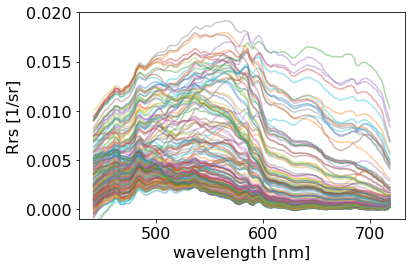

In [301]:
rand_ints = np.random.randint(masked_flat_xds.shape[0],size=(200))

for spec_i in rand_ints:
    plt.plot(wls[42:],masked_flat_xds[spec_i],alpha=0.4)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')
plt.ylim(-0.001,0.02)
# plt.axhline(0,c='k')

# plt.axvline(537)

plt.tight_layout()

plt.savefig('figs/spectra_examples_pace_oci.png',dpi=300)

plt.show()

How does this look normalized to 512nm

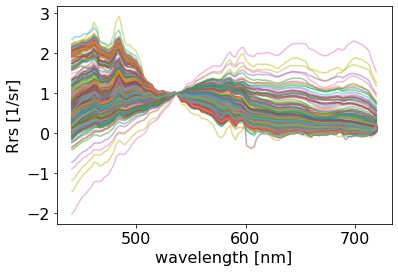

In [162]:
for spec_i in rand_ints:
    plt.plot(wls[42:],masked_flat_xds[spec_i]/masked_flat_xds[spec_i,38],alpha=0.5)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')

# plt.savefig('figs/spectra_examples_nw_atlantic_oci.png',dpi=300)

plt.show()

Formulate the samples for clustering and anomaly detection as the normalized spectra

In [163]:
masked_flat_xds.T.shape

(142, 57528)

In [164]:
X = (masked_flat_xds.T/masked_flat_xds[:,38]).T

Check that these look sane

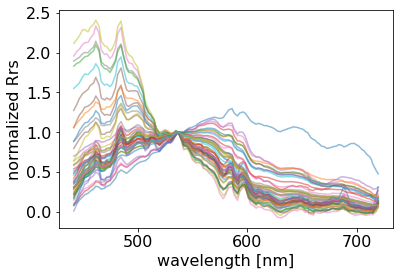

In [165]:
rand_ints = np.random.randint(masked_flat_xds.shape[0],size=(50))

for spec_i in rand_ints:
    plt.plot(wls[42:],X[spec_i],alpha=0.5)

plt.xlabel('wavelength [nm]')
plt.ylabel('normalized Rrs')

# plt.savefig('figs/spectra_examples_nw_atlantic_oci.png',dpi=300)

plt.show()

Determine the ideal number of clustering use an elbow plot. This can take some time.

Text(0.5, 1.0, 'Elbow curve')

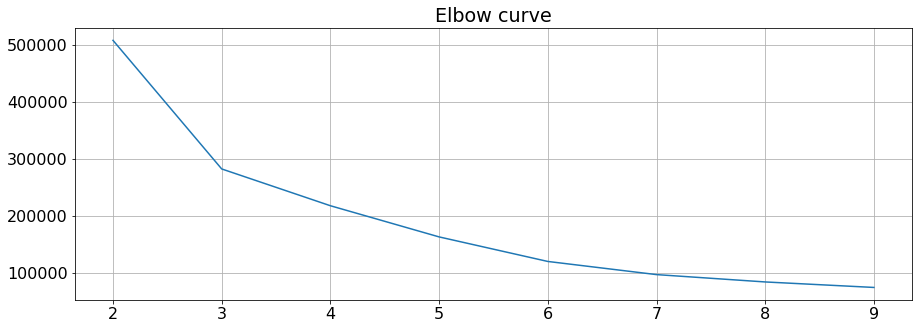

In [166]:
distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

This looks like somewhere between 3-5. Let's go on the more inclusive side. Now run a clustering with 5 groups.

In [167]:
kmeans = KMeans(n_clusters=6).fit(X)

In [168]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([28238, 10635,  1467,    11,  7147, 10030]))

Make a matrix of the same dimensions as the original dataset. 

Here I'm setting the default to -1 so the nan values will stay in a cluster of ID -1

In [169]:
flat_xds.shape[0], kmeans.labels_.shape

(2175120, (57528,))

In [170]:
all_clusters = np.zeros(flat_xds.shape[0])-1
all_clusters[mask] = kmeans.labels_

In [171]:
counts = np.unique(all_clusters, return_counts=True)
counts

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 array([2117592,   28238,   10635,    1467,      11,    7147,   10030]))

In [172]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(X)

In [173]:
all_pca = np.zeros((flat_xds.shape[0],2))
all_pca[:] = np.nan
all_pca[mask] = pca

Specify a colorblind friendly color palatte

In [235]:
colors = ['#ff7f00', '#377eb8', '#a65628','#f781bf', '#4daf4a', '#984ea3']

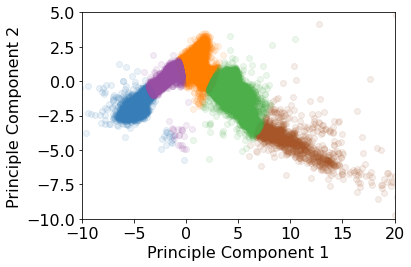

In [386]:
fig, ax = plt.subplots()

plt.xlim(-10,20)
plt.ylim(-10,5)

for cluster_n in [0,1,2,4,5]:
    ax.scatter(pca[:,0][kmeans.labels_==cluster_n],pca[:,1][kmeans.labels_==cluster_n],color=colors[cluster_n],alpha=0.1)

    
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')

plt.tight_layout()


plt.savefig('figs/pca_pace.png',dpi=300)

What do the average spectra look like in these four "clusters"

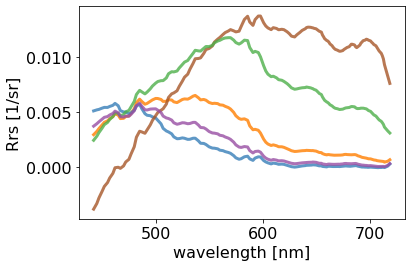

In [296]:
for cluster_n in [0,1,2,4,5]:
    plt.plot(wls[42:],np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0),color=colors[cluster_n],alpha=0.8,lw=3)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')

plt.tight_layout()

plt.savefig('figs/spectra_examples_pace.png',dpi=300)

plt.show()

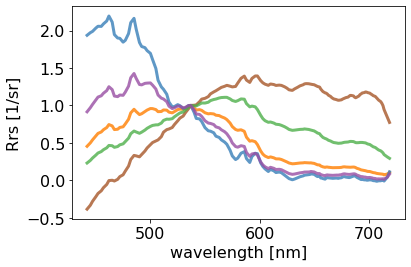

In [295]:
for cluster_n in [0,1,2,4,5]:
    plt.plot(wls[42:],np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)/np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)[38],color=colors[cluster_n],alpha=0.8,lw=3)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')

plt.tight_layout()

plt.savefig('figs/spectra_examples_pace_normed.png',dpi=300)

plt.show()

Turn the cluster IDs back into a grid and put them back into our xarray Dataset

In [196]:
# kmeans_grid = all_clusters.reshape(1709,1272)
kmeans_grid = all_clusters.reshape(1710,1272)

In [197]:
xds_subset['kmeans_clusters'] = xr.DataArray(kmeans_grid, dims=['x', 'y'])

In [226]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','white','white','white','white','#ff7f00', '#377eb8', '#a65628',
                  '#f781bf', '#4daf4a', '#984ea3',])

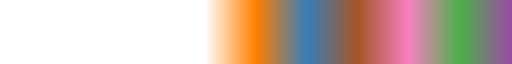

In [227]:
cmap

In [201]:
matplotlib.rcParams.update({'font.size': 16})

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


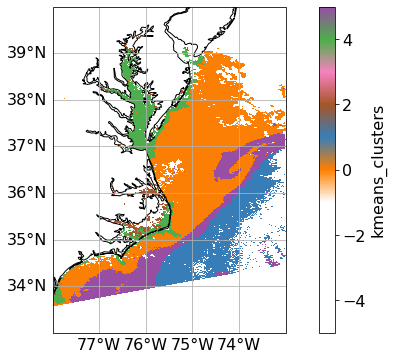

In [234]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

# ax.set_xlim(-65,-55)
# ax.set_ylim(20,30)

ax.set_xlim(-78,-73)
ax.set_ylim(33,40)

xds_subset.kmeans_clusters.plot(ax=ax, x='longitude', y='latitude', cmap=cmap)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.savefig('figs/cluster_map_pace.png',dpi=300)

plt.show()

In [262]:
core_clusters = np.array([np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0) for cluster_n in [0,1,2,4,5]])
core_clusters = (core_clusters.T/core_clusters[:,38]).T

In [229]:
from sklearn.metrics.pairwise import cosine_similarity

In [267]:
cos_sim = cosine_similarity(X, core_clusters)

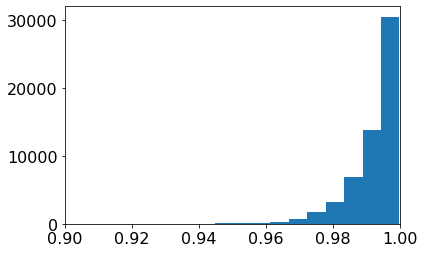

In [280]:
plt.hist(np.max(cos_sim,axis=1),bins=200)
plt.xlim(.9,1)
plt.show()

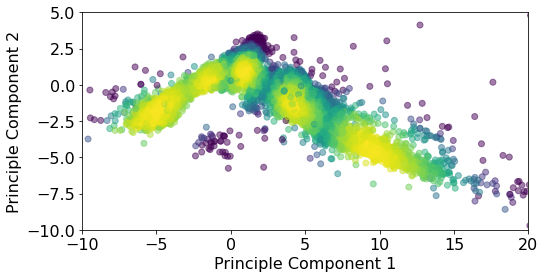

In [385]:
fig, ax = plt.subplots(figsize=(8,4))

plt.xlim(-10,20)
plt.ylim(-10,5)

ax.scatter(pca[:,0],pca[:,1],c=np.max(cos_sim,axis=1),alpha=0.5,vmin=.94,vmax=1)

    
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')


# plt.savefig('figs/pca_pace.png',dpi=300)

plt.show()

In [314]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=42)

clf = clf.fit(pca)

outliers = clf.decision_function(pca)

In [347]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=250)
clf.fit(pca)

LocalOutlierFactor(n_neighbors=250)

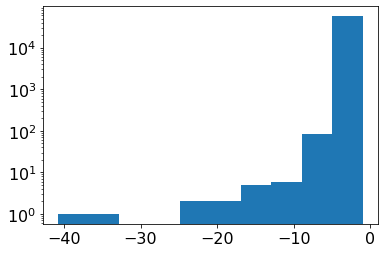

In [348]:
plt.hist(clf.negative_outlier_factor_)
plt.yscale('log')


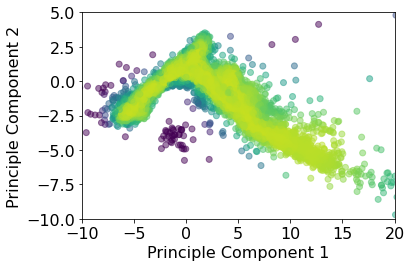

In [384]:
fig, ax = plt.subplots()

plt.xlim(-10,20)
plt.ylim(-10,5)

ax.scatter(pca[:,0],pca[:,1],c=clf.negative_outlier_factor_,alpha=0.5,vmin=-6,vmax=-.5)

    
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')

plt.tight_layout()

plt.savefig('figs/pca_pace_anomaly.png',dpi=300)

plt.show()

In [350]:
all_cos_sim = np.zeros(flat_xds.shape[0])
all_cos_sim[:] = np.nan
# all_cos_sim[mask] = np.max(cos_sim,axis=1)

all_cos_sim[mask] = clf.negative_outlier_factor_

cos_sim_grid = all_cos_sim.reshape(1710,1272)

xds_subset['cos_sim'] = xr.DataArray(cos_sim_grid, dims=['x', 'y'])

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


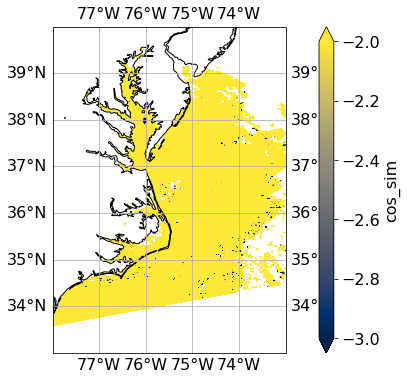

In [351]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

# ax.set_ylim(36,42)
# ax.set_xlim(-72.5,-70)

# ax.set_xlim(-65,-55)
# ax.set_ylim(20,30)

# ax.set_ylim(22.5,31.3)
# ax.set_xlim(-93,-84)

ax.set_xlim(-78,-73)
ax.set_ylim(33,40)

xds_subset.cos_sim.plot(ax=ax, x='longitude', y='latitude', cmap='cividis',vmin=-5,vmax=0)

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

In [369]:
clf.negative_outlier_factor_.shape

(57528,)

In [372]:
ind = np.argpartition(clf.negative_outlier_factor_, 500)[:500]

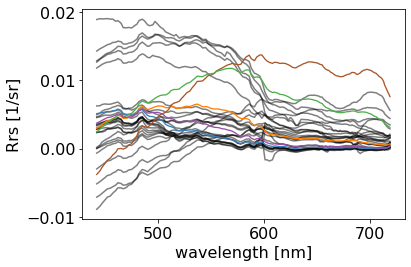

In [390]:
plt.plot(wls[42:],masked_flat_xds[ind].T[:,::20],c='k', alpha=0.5)

for cluster_n in [0,1,2,4,5]:
    plt.plot(wls[42:],np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0),color=colors[cluster_n],alpha=1,lw=1.3)

plt.xlabel('wavelength [nm]')
plt.ylabel('Rrs [1/sr]')

plt.tight_layout()

plt.savefig('figs/anomaly_spectra,png',dpi=300)

plt.show()

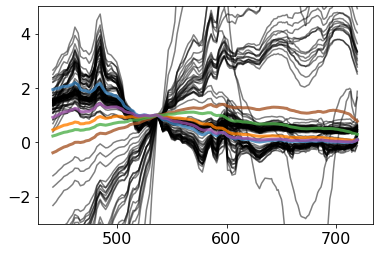

In [353]:
plt.plot(wls[42:],masked_flat_xds[ind].T[:]/masked_flat_xds[ind].T[38],c='k', alpha=0.5)
for cluster_n in [0,1,2,4,5]:
    plt.plot(wls[42:],np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)/np.mean(masked_flat_xds[kmeans.labels_==cluster_n],axis=0)[38],color=colors[cluster_n],alpha=0.8,lw=3)

plt.ylim(-3,5)
plt.show()